In [1]:
import os
import sys
import shutil
import json
import pandas as pd
import numpy as np

# set environment variable here.
os.environ["nnUNet_preprocessed"] = "/home/bhatti_uhn/nnUNet_preprocessed"
os.environ["nnUNet_results"] = "/home/bhatti_uhn/nnUNet_results"
os.environ["nnUNet_raw"] = "/home/bhatti_uhn/nnUNet_raw"

# Ensure that environment variables are set correctly # from run_training.py
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

import logging

from sklearn.metrics import classification_report

logging.basicConfig(level=logging.WARNING)

In [2]:
# read the "/home/bhatti_uhn/nnUNet_results/Dataset876_UHNMedImg3D/nnUnetSegClsTrainer__nnUNetPlans__3d_fullres/fold_all/validation" directory and classification.npy file.
# store in a df and save to csv
# df template: Name | Label | SubType (Prediction)

def get_classification_results(valSrcPath, classification_files, isval=True):

    if isval:
        df = pd.DataFrame(columns=['Name', 'Label', 'SubType'])
    else:
        df = pd.DataFrame(columns=['Name', 'SubType'])

    for classFile in classification_files:
        classFilePath = os.path.join(valSrcPath, classFile)

        if isval:
            # target class
            target_class = int(classFile.split('_')[1])

        # Load the classification file
        classification = np.load(classFilePath)
        # keep argmax only
        class_pred = np.argmax(classification, axis=-1)

        # Create a DataFrame
        if isval:
            new_row = pd.DataFrame({'Name': [classFile.replace('_classification.npy', '.nii.gz')], 'Label': [int(target_class)], 'SubType': class_pred})
        else:
            new_row = pd.DataFrame({'Name': [classFile.replace('_classification.npy', '.nii.gz')], 'SubType': class_pred})

        df = pd.concat([df, new_row], ignore_index=True)

    # Save the DataFrame to a CSV file
    df.to_csv(os.path.join(valSrcPath, "classification_results.csv"), index=False)

    print(f"Saved classification to {os.path.join(valSrcPath, "classification_results.csv")}")

    return df

# Define the path to the classification file
valSrcPath = "/home/bhatti_uhn/nnUNet_raw/Dataset877_UHNMedImg3DVAL/imagesTr_3d_fullres"

# list classification.npy files
classification_files = [sdir for sdir in sorted(os.listdir(valSrcPath)) if sdir.split('_')[-1] == 'classification.npy']

df = get_classification_results(valSrcPath, classification_files)

Saved classification to /home/bhatti_uhn/nnUNet_raw/Dataset877_UHNMedImg3DVAL/imagesTr_3d_fullres/classification_results.csv


In [25]:
# get the classification report on test set.
testSrcPath = "/home/bhatti_uhn/nnUNet_raw/Dataset876_UHNMedImg3D/imagesTs_3d_fullres"
test_classification_files = [sdir for sdir in sorted(os.listdir(testSrcPath)) if sdir.split('_')[-1] == 'classification.npy']
df_test = get_classification_results(testSrcPath, test_classification_files, isval=False)

Saved classification to /home/bhatti_uhn/nnUNet_raw/Dataset876_UHNMedImg3D/imagesTs_3d_fullres/classification_results.csv


In [26]:
df_test

,Name,SubType
0,quiz_037.nii.gz,1
1,quiz_045.nii.gz,2
2,quiz_047.nii.gz,1
3,quiz_048.nii.gz,2
4,quiz_052.nii.gz,1
...,...,...
67,quiz_504.nii.gz,1
68,quiz_512.nii.gz,2
69,quiz_520.nii.gz,1
70,quiz_521.nii.gz,2


In [3]:
def get_classification_scores_on_validation(df):
# Ensure labels are of integer type
    df['Label'] = df['Label'].astype(int)
    df['SubType'] = df['SubType'].astype(int)

    # Convert columns to numpy arrays
    preds = df['SubType'].values
    targets = df['Label'].values

    len(preds), len(targets)

    # Calculate accuracy
    accuracy = np.mean(preds == targets)
    print(f"Accuracy: {accuracy}")

    print(classification_report(preds, targets))

get_classification_scores_on_validation(df)

Accuracy: 0.5833333333333334
              precision    recall  f1-score   support

           0       0.44      1.00      0.62         4
           1       0.67      0.59      0.62        17
           2       0.58      0.47      0.52        15

    accuracy                           0.58        36
   macro avg       0.56      0.68      0.59        36
weighted avg       0.61      0.58      0.58        36



In [4]:
df

,Name,Label,SubType
0,quiz_0_168.nii.gz,0,1
1,quiz_0_171.nii.gz,0,0
2,quiz_0_174.nii.gz,0,2
3,quiz_0_184.nii.gz,0,2
4,quiz_0_187.nii.gz,0,0
5,quiz_0_189.nii.gz,0,1
6,quiz_0_244.nii.gz,0,2
7,quiz_0_253.nii.gz,0,0
8,quiz_0_254.nii.gz,0,0
9,quiz_1_090.nii.gz,1,1


In [11]:
# plot .nii.gz files.

# Load the .nii.gz files
import nibabel as nib
import matplotlib.pyplot as plt

def plot_nii_gz_files(valSrcPath, df):
    for idx, row in df.iterrows():
        # Load the .nii.gz file
        nii_file = row['Name']
        nii_path = os.path.join(valSrcPath, nii_file)
        nii_img = nib.load(nii_path)
        nii_data = nii_img.get_fdata()

        # Plot the .nii.gz file
        plt.figure(figsize=(10, 10))
        plt.imshow(nii_data[:, :, 50], cmap='gray')
        plt.title(f"{nii_file} - {row['SubType']}")
        plt.show()

array([2])

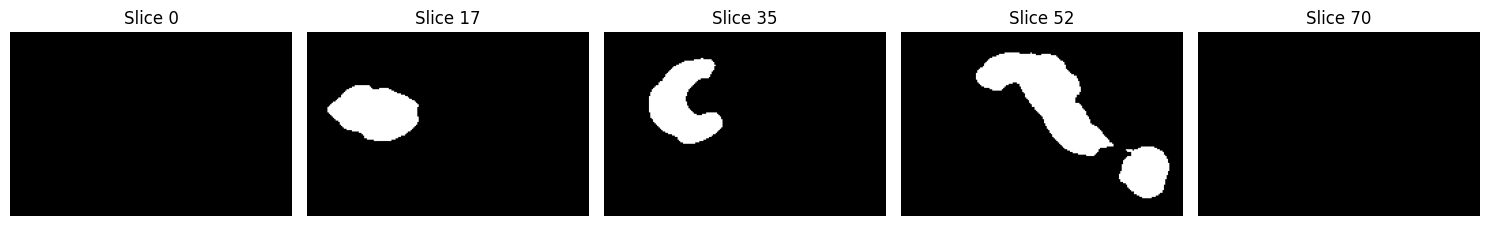

In [5]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

# Ensure plots are rendered inline in the notebook
%matplotlib inline

# Load the NIfTI file
file_path = "/home/bhatti_uhn/nnUNet_raw/Dataset876_UHNMedImg3D/imagesTs_3d_fullres/quiz_037.nii.gz"
image = sitk.ReadImage(file_path)
image_array = sitk.GetArrayFromImage(image)

# Plot a few slices from the 3D image
num_slices = image_array.shape[0]

# Select slices to plot (for example, 5 evenly spaced slices)
slice_indices = np.linspace(0, num_slices - 1, 5, dtype=int)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(slice_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(image_array[idx, :, :], cmap="gray")
    plt.title(f"Slice {idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()

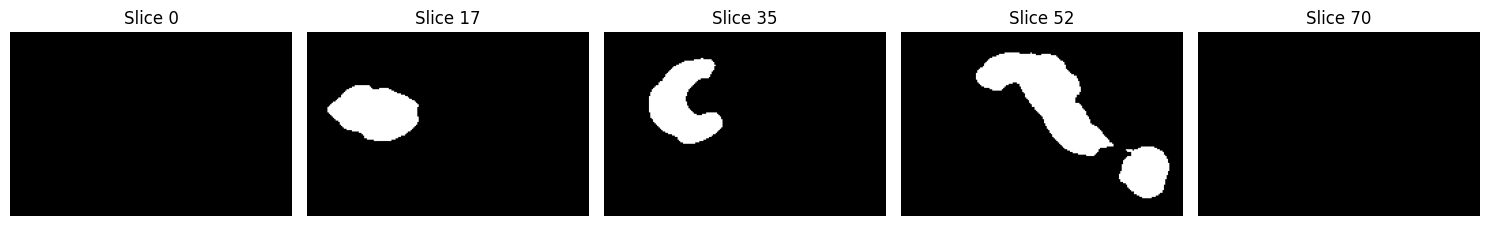

In [6]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

# Ensure plots are rendered inline in the notebook
%matplotlib inline

# Load the NIfTI file
file_path = "/home/bhatti_uhn/nnUNet_raw/Dataset876_UHNMedImg3D/imagesTs_3d_fullres/quiz_037.nii.gz"
image = sitk.ReadImage(file_path)
image_array = sitk.GetArrayFromImage(image)

# Function to plot slices
def plot_slices(image_array, num_slices=5):
    total_slices = image_array.shape[0]
    slice_indices = np.linspace(0, total_slices - 1, num_slices, dtype=int)
    
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(slice_indices):
        plt.subplot(1, num_slices, i + 1)
        plt.imshow(image_array[idx, :, :], cmap="gray")
        plt.title(f"Slice {idx}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Plot 5 slices
plot_slices(image_array, num_slices=5)

In [21]:
import nibabel as nib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Load the NIfTI file
img_path = "/home/bhatti_uhn/nnUNet_raw/Dataset877_UHNMedImg3DVAL/imagesTr_3d_fullres/quiz_0_168.nii.gz"
img = nib.load(img_path)
image_array = img.get_fdata()

# Function to update plot
def update_plot(slice_idx):
    plt.figure(figsize=(5, 5))
    plt.imshow(image_array[:, :, slice_idx], cmap="viridis", vmin=0, vmax=2)
    plt.title(f"Slice {slice_idx}")
    plt.axis("off")
    plt.show()

# Interactive widget
slice_slider = widgets.IntSlider(min=0, max=image_array.shape[2] - 1, step=1, value=0)
interactive_plot = widgets.interactive(update_plot, slice_idx=slice_slider)

# Display the slider and interactive plot
display(interactive_plot)
display(slice_slider)

interactive(children=(IntSlider(value=0, description='slice_idx', max=60), Output()), _dom_classes=('widget-in…

IntSlider(value=0, description='slice_idx', max=60)

In [20]:
import nibabel as nib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Load the NIfTI file
img_path = "/home/bhatti_uhn/nnUNet_raw/Dataset877_UHNMedImg3DVAL/labelsTr/quiz_0_168.nii.gz"
img = nib.load(img_path)
image_array = img.get_fdata()

# Function to update plot
def update_plot(slice_idx):
    plt.figure(figsize=(5, 5))
    plt.imshow(image_array[:, :, slice_idx], cmap="viridis", vmin=0, vmax=2)
    plt.title(f"Slice {slice_idx}")
    plt.axis("off")
    plt.show()

# Interactive widget
slice_slider = widgets.IntSlider(min=0, max=image_array.shape[2] - 1, step=1, value=0)
interactive_plot = widgets.interactive(update_plot, slice_idx=slice_slider)

# Display the slider and interactive plot
display(interactive_plot)
display(slice_slider)

interactive(children=(IntSlider(value=0, description='slice_idx', max=60), Output()), _dom_classes=('widget-in…

IntSlider(value=0, description='slice_idx', max=60)

In [22]:
import nibabel as nib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Load the NIfTI file
img_path = "/home/bhatti_uhn/nnUNet_raw/Dataset877_UHNMedImg3DVAL/imagesTr/quiz_0_168_0000.nii.gz"
img = nib.load(img_path)
image_array = img.get_fdata()

# Function to update plot
def update_plot(slice_idx):
    plt.figure(figsize=(5, 5))
    plt.imshow(image_array[:, :, slice_idx], cmap="viridis", vmin=0, vmax=2)
    plt.title(f"Slice {slice_idx}")
    plt.axis("off")
    plt.show()

# Interactive widget
slice_slider = widgets.IntSlider(min=0, max=image_array.shape[2] - 1, step=1, value=0)
interactive_plot = widgets.interactive(update_plot, slice_idx=slice_slider)

# Display the slider and interactive plot
display(interactive_plot)
display(slice_slider)

interactive(children=(IntSlider(value=0, description='slice_idx', max=60), Output()), _dom_classes=('widget-in…

IntSlider(value=0, description='slice_idx', max=60)